<a href="https://colab.research.google.com/github/bghaendler/BJBS-AI-LAB/blob/master/BJBS_AI_Lab_Session_02_CoronaVirus_Conv2019.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img width="300" src="https://raw.githubusercontent.com/bghaendler/BJBS-AI-LAB/master/img/BJBSAILogo.png" align="right"> 
# Session 2: CoronaVirus -Conv2019 Analysis

## Downloading the data from Kaggle

In [1]:
import os
os.environ['KAGGLE_USERNAME'] = "bghai19" # username from the json file
os.environ['KAGGLE_KEY'] = "4947c3935b9ad98eacd876741ff7c11c" # key from the json file
!kaggle datasets download -d sudalairajkumar/novel-corona-virus-2019-dataset # api copied from kaggle

  0% 0.00/19.5k [00:00<?, ?B/s]
100% 19.5k/19.5k [00:00<00:00, 30.6MB/s]


In [0]:
import zipfile
with zipfile.ZipFile("/content/novel-corona-virus-2019-dataset.zip","r") as zip_ref:
    zip_ref.extractall("input")

## Libraries

We import all the necessary packages. We are going to work with the fastai V1 library which sits on top of Pytorch 1.0. The fastai library provides many useful functions that enable us to quickly and easily build neural networks and train our models.

In [116]:
!pip install geopy

In [0]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import auc,roc_curve
from geopy.geocoders import Nominatim

In [6]:
import os
print(os.listdir("input"))

['time_series_2019_ncov_recovered.csv', '2019_nCoV_data.csv', 'time_series_2019_ncov_confirmed.csv', 'time_series_2019_ncov_deaths.csv']


## Exploratory Data Analysis

In [0]:
df_corona = pd.read_csv(os.path.join('/content/input/2019_nCoV_data.csv'), parse_dates=["Date","Last Update"])

### Calculate Mortality Rate

In [0]:
df_corona["MortalityRate"] = df_corona["Deaths"]/df_corona["Confirmed"]
df_corona["MortalityRate"].replace([np.inf, -np.inf], np.nan)
df_corona["MortalityRate"].fillna(value=0, inplace=True)
#df_corona["MortalityRate"] = df_corona["MortalityRate"].str.replace("inf","0")

In [143]:
df_corona["MortalityRate"].loc[(~np.isfinite(df_corona["MortalityRate"])) & df_corona["MortalityRate"].notnull()] = 0

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


### Geolocation

In [0]:
df_corona.loc[df_corona["Province/State"].isna(),"Province/State"] = df_corona["Country"]
df_corona.loc[df_corona["Province/State"] == "Diamond Princess cruise ship","Province/State"] = "Japan"

In [146]:
#df_corona.loc[df_corona["Province/State"].isna()]

,Sno,Date,Province/State,Country,Last Update,Confirmed,Deaths,Recovered,MortalityRate


In [156]:
geolocator = Nominatim(user_agent="specify_your_app_name_here")
location = geolocator.geocode("Japan")
print((location.latitude, location.longitude))

(36.5748441, 139.2394179)


In [164]:
#df_corona["Latitude"] = df_corona["Province/State"].apply(geolocator.geocode)
df_corona['Coordinates'] = df_corona["Province/State"].apply(geolocator.geocode).apply(lambda x: (x.latitude, x.longitude))


GeocoderServiceError: ignored

In [162]:
for item in set(df_corona["Province/State"]):
  #print(item)
  #geolocator = Nominatim(user_agent="specify_your_app_name_here")
  location = geolocator.geocode(item)
  print((location.latitude, location.longitude),end=": ")
  print(item)


(7.5554942, 80.7137847): Sri Lanka
(28.1083929, 84.0917139): Nepal
(-10.3333333, -53.2): Brazil
(25.0, 102.0): Yunnan
(35.40709525, 95.95211573241954): Qinghai
(36.5748441, 139.2394179): Japan
(42.988576, -81.246643): London, ON
(31.894343149999997, 87.07813712706509): Tibet
(50.6402809, 4.6667145): Belgium
(30.05518, 107.8748712): Chongqing
(12.7503486, 122.7312101): Philippines
(40.9975197, 122.9955469): Liaoning
(7.9897371, -5.5679458): Ivory Coast
(-31.8759835, 147.2869493): New South Wales
(19.2000001, 109.5999999): Hainan
(24.0002488, 53.9994829): United Arab Emirates
(30.5000001, 102.4999999): Sichuan
(22.1757605, 113.5514142): Macau
(55.001251, -125.002441): British Columbia
(64.6863136, 97.7453061): Russia
(36.5581914, 127.9408564): South Korea
(47.6038321, -122.3300624): Seattle, WA
(46.603354, 1.8883335): France
(40.0796606, -89.4337288): Illinois
(41.8755616, -87.6244212): Chicago
(4.5693754, 102.2656823): Malaysia
(33.4255056, -111.9400125): Tempe, AZ
(27.0, 107.0): Guizho

In [170]:
# import the library
import folium
import pandas as pd
 
# Make a data frame with dots to show on the map
data = pd.DataFrame({
   'lat':[-58, 2, 145, 30.32, -4.03, -73.57, 36.82, -38.5],
   'lon':[-34, 49, -38, 59.93, 5.33, 45.52, -1.29, -12.97],
   'name':['Buenos Aires', 'Paris', 'melbourne', 'St Petersbourg', 'Abidjan', 'Montreal', 'Nairobi', 'Salvador'],
   'value':[10,12,40,70,23,43,100,43]
})
data
 
# Make an empty map
m = folium.Map(location=[20,0], tiles="Mapbox Bright", zoom_start=2)
 
# I can add marker one by one on the map
for i in range(0,len(data)):
   folium.Circle(
      location=[data.iloc[i]['lon'], data.iloc[i]['lat']],
      popup=data.iloc[i]['name'],
      radius=data.iloc[i]['value']*float(10000),
      #color='crimson',
      #fill=True,
      #fill_color='crimson'
   ).add_to(m)
m

In [115]:
df_corona.groupby(by=["Date","Country"]).count()

Sno  ...  MortalityRate
Date                Country                    ...               
2020-01-22 12:00:00 China                  34  ...             34
                    Japan                   1  ...              1
                    South Korea             1  ...              1
                    Thailand                1  ...              1
                    US                      1  ...              1
...                                       ...  ...            ...
2020-02-09 23:20:00 Thailand                1  ...              1
                    UK                      1  ...              1
                    US                      9  ...              9
                    United Arab Emirates    1  ...              1
                    Vietnam                 1  ...              1

[419 rows x 7 columns]

In [110]:
df_corona.loc[df_corona["Province/State"] =="Hunan"].sort_values(by="Date")

,Sno,Date,Province/State,Country,Last Update,Confirmed,Deaths,Recovered,MortalityRate
14,15,2020-01-22 12:00:00,Hunan,China,2020-01-22 12:00:00,4.0,0.0,0.0,0.000000
52,53,2020-01-23 12:00:00,Hunan,Mainland China,2020-01-23 12:00:00,9.0,0.0,0.0,0.000000
88,89,2020-01-24 12:00:00,Hunan,Mainland China,2020-01-24 12:00:00,24.0,0.0,0.0,0.000000
129,130,2020-01-25 22:00:00,Hunan,Mainland China,2020-01-25 12:00:00,69.0,0.0,0.0,0.000000
173,174,2020-01-26 23:00:00,Hunan,Mainland China,2020-01-26 23:00:00,100.0,0.0,0.0,0.000000
221,222,2020-01-27 20:30:00,Hunan,Mainland China,2020-01-27 20:30:00,100.0,0.0,0.0,0.000000
270,271,2020-01-28 23:00:00,Hunan,Mainland China,2020-01-28 23:00:00,221.0,0.0,0.0,0.000000
323,324,2020-01-29 21:00:00,Hunan,Mainland China,2020-01-29 21:00:00,277.0,0.0,0.0,0.000000
379,380,2020-01-30 21:30:00,Hunan,Mainland China,2020-01-30 21:30:00,332.0,0.0,2.0,0.000000
438,439,2020-01-31 19:00:00,Hunan,Mainland China,2020-01-31 19:00:00,332.0,0.0,3.0,0.000000


In [88]:
df_corona.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1127 entries, 0 to 1126
Data columns (total 9 columns):
Sno               1127 non-null int64
Date              1127 non-null datetime64[ns]
Province/State    837 non-null object
Country           1127 non-null object
Last Update       1127 non-null datetime64[ns]
Confirmed         1127 non-null float64
Deaths            1127 non-null float64
Recovered         1127 non-null float64
MortalityRate     1127 non-null float64
dtypes: datetime64[ns](2), float64(4), int64(1), object(2)
memory usage: 79.4+ KB


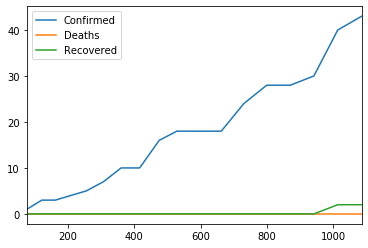

In [89]:
df_corona[df_corona["Country"]=="Singapore"][["Confirmed","Deaths","Recovered"]].plot()

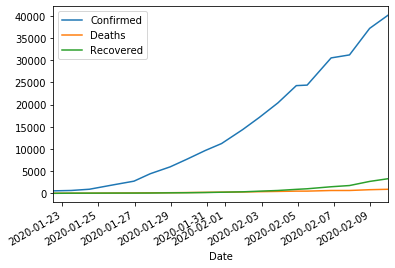

In [90]:
df_corona[["Date","Confirmed","Deaths","Recovered"]].loc[df_corona["Country"].str.contains("China")].groupby(by="Date").sum().plot()

In [97]:
df_corona[["Date","Country","MortalityRate"]].loc[df_corona["Country"].str.contains("China")].groupby(by=["Date","Country"]).mean()#.plot()

,,MortalityRate
Date,Country,
2020-01-22 12:00:00,China,0.000000
2020-01-23 12:00:00,Mainland China,0.033493
2020-01-24 12:00:00,Mainland China,0.026457
2020-01-25 22:00:00,Mainland China,0.007299
2020-01-26 23:00:00,Mainland China,0.006109
2020-01-27 20:30:00,Mainland China,0.005863
2020-01-28 23:00:00,Mainland China,0.004650
2020-01-29 21:00:00,Mainland China,0.004205
2020-01-30 21:30:00,Mainland China,0.004150


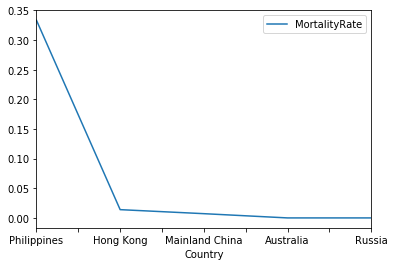

In [104]:
df_corona[["Date","Country","MortalityRate"]].groupby(by=["Country"]).mean().sort_values(by="MortalityRate",ascending=False).head(5).plot()

In [79]:
df_corona[["Country","Date","Confirmed","Deaths","Recovered"]].loc[df_corona["Date"] ==df_corona["Date"].max()].groupby(by=["Country"]).sum().sort_values(by="Confirmed", ascending=False)

,Confirmed,Deaths,Recovered
Country,,,
Mainland China,40160.0,908.0,3286.0
Others,64.0,0.0,0.0
Singapore,43.0,0.0,2.0
Hong Kong,36.0,1.0,0.0
Thailand,32.0,0.0,10.0
South Korea,27.0,0.0,3.0
Japan,26.0,0.0,1.0
Taiwan,18.0,0.0,1.0
Malaysia,18.0,0.0,1.0


In [80]:
print(image_dataframe.cell_type.value_counts())

NameError: ignored

## Plot

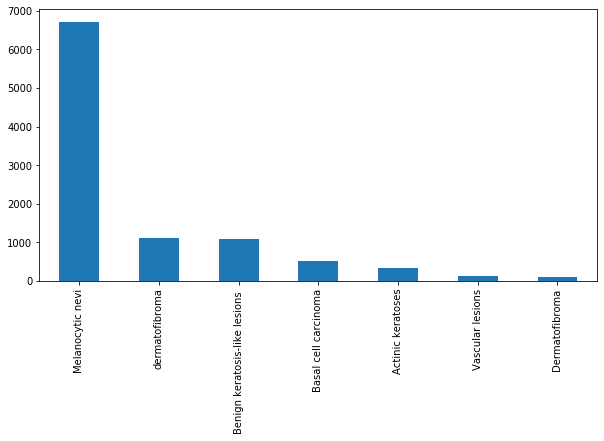

In [0]:
fig, ax1 = plt.subplots(1, 1, figsize= (10, 5))
image_dataframe['cell_type'].value_counts().plot(kind='bar', ax=ax1)

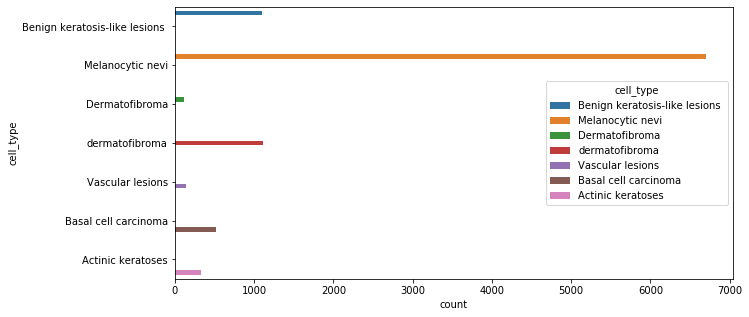

In [0]:
fig, ax1 = plt.subplots(1, 1, figsize = (10, 5))
sns.countplot(y='cell_type',data=image_dataframe, hue="cell_type",ax=ax1)




Here we notice tha we have data imbalance

In [0]:
image_dataset = pd.concat([image_dataframe['path'], image_dataframe['cell_type']], axis=1, keys=['name', 'label'])

image_dataset.head(5)

,name,label
0,input/ham10000_images_part_1/ISIC_0027419.jpg,Benign keratosis-like lesions
1,input/ham10000_images_part_1/ISIC_0025030.jpg,Benign keratosis-like lesions
2,input/ham10000_images_part_1/ISIC_0026769.jpg,Benign keratosis-like lesions
3,input/ham10000_images_part_1/ISIC_0025661.jpg,Benign keratosis-like lesions
4,input/HAM10000_images_part_2/ISIC_0031633.jpg,Benign keratosis-like lesions


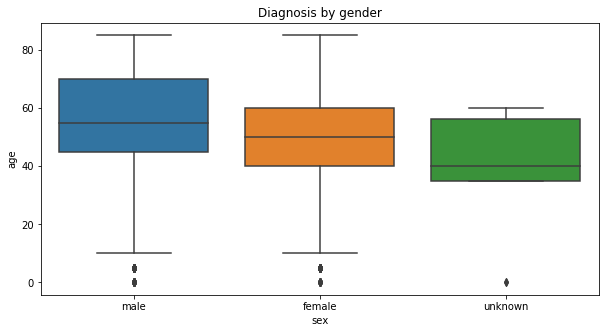

In [0]:
f, ax1 = plt.subplots(1,1, figsize=(10,5))
sns.boxplot(
    x=image_dataframe['sex'], 
    y=image_dataframe['age'], 
    #hue=image_dataframe['sex'], 
    ax=ax1)
plt.title('Diagnosis by gender')
plt.show()

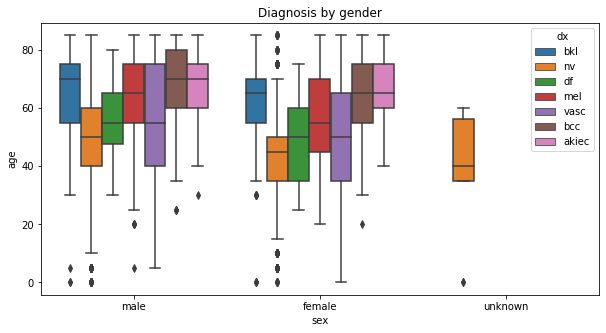

In [0]:
f, ax1 = plt.subplots(1,1, figsize=(10,5))
sns.boxplot(x=image_dataframe['sex'], y=image_dataframe['age'], hue=image_dataframe['dx'], ax=ax1)
plt.title('Diagnosis by gender')
plt.show()

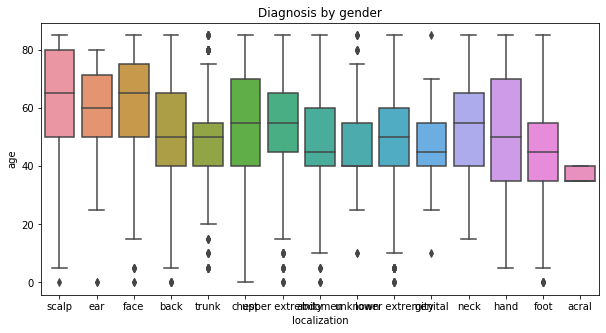

In [0]:
f, ax1 = plt.subplots(1,1, figsize=(10,5))
sns.boxplot(x=image_dataframe['localization'], y=image_dataframe['age'], ax=ax1)
plt.title('Diagnosis by gender')
plt.show()

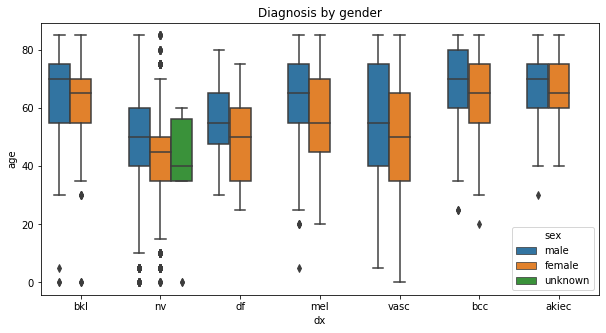

In [0]:
f, ax1 = plt.subplots(1,1, figsize=(10,5))
sns.boxplot(x=image_dataframe['dx'], y=image_dataframe['age'], hue=image_dataframe['sex'], ax=ax1)
plt.title('Diagnosis by gender')
plt.show()

In [0]:
bs = 64

tfms = get_transforms(do_flip=False)
data = ImageDataBunch.from_df(".", image_dataset, ds_tfms=tfms, size=28, bs=bs).normalize(imagenet_stats)

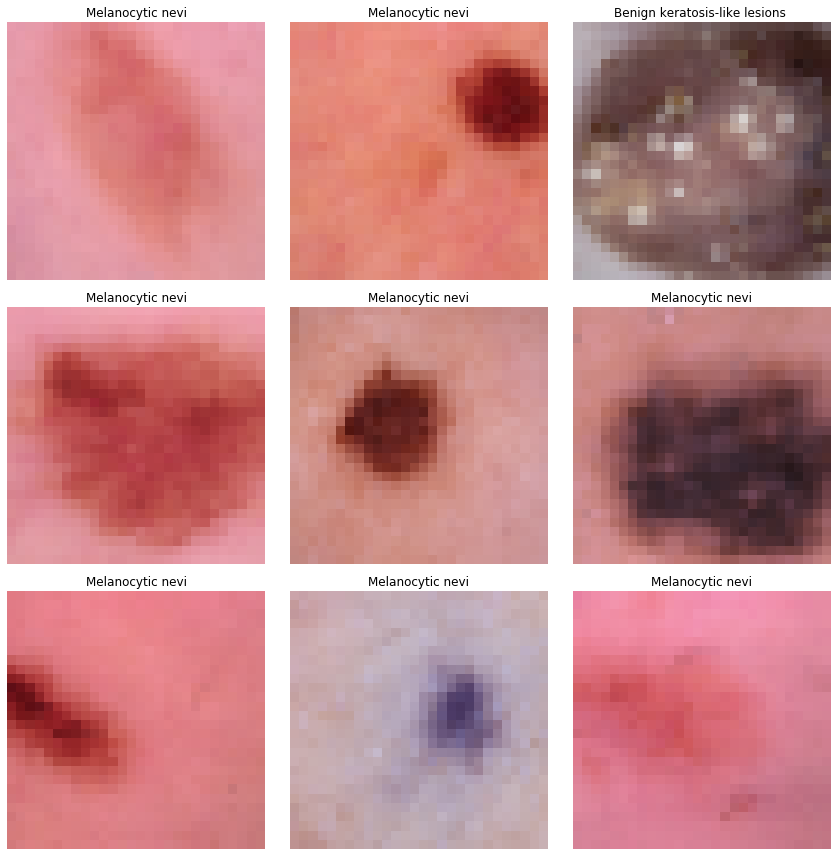

In [0]:
data.show_batch(rows=3, figsize=(12,12))

## Model Resnet 50

- Now we will train in the same way as before but with one caveat: instead of using resnet34 as our backbone we will use resnet50 (resnet34 is a 34 layer residual network while resnet50 has 50 layers. It will be explained later in the course and you can learn the details in the resnet paper).

<img width="900" src="https://i.stack.imgur.com/gI4zT.png">

https://arxiv.org/pdf/1512.03385.pdf

- Basically, resnet50 usually performs better because it is a deeper network with more parameters. Let's see if we can achieve a higher performance here. To help it along, let's us use larger images too, since that way the network can see more detail. We reduce the batch size a bit since otherwise this larger network will require more GPU memory.

In [0]:
learner=create_cnn(data,models.resnet50,metrics=[accuracy], model_dir="/tmp/model/")

/usr/local/lib/python3.6/dist-packages/fastai/vision/learner.py:106: UserWarning: `create_cnn` is deprecated and is now named `cnn_learner`.
  warn("`create_cnn` is deprecated and is now named `cnn_learner`.")
Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


In [0]:
#learner.model

In [0]:
learner.loss_func=nn.CrossEntropyLoss()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


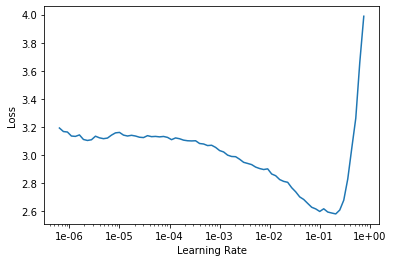

In [0]:
learner.lr_find()
learner.recorder.plot()

In [0]:
learner.fit_one_cycle(2, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.386809,0.891506,0.697454,01:45
1,0.908091,0.800963,0.721418,01:41


In [0]:
learner.unfreeze()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


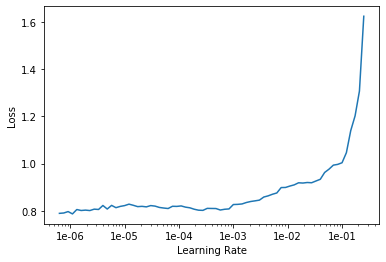

In [0]:
learner.lr_find()
learner.recorder.plot()

In [0]:
lr=1e-6
learner.fit_one_cycle(3, slice(3*lr,10*lr))

epoch,train_loss,valid_loss,accuracy,time
0,0.845703,0.776249,0.724413,01:40
1,0.833156,0.764201,0.723914,01:40
2,0.802706,0.766958,0.728407,01:40


In [0]:
learner.save('stage-1')

In [0]:
interp = ClassificationInterpretation.from_learner(learner)

In [0]:


losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

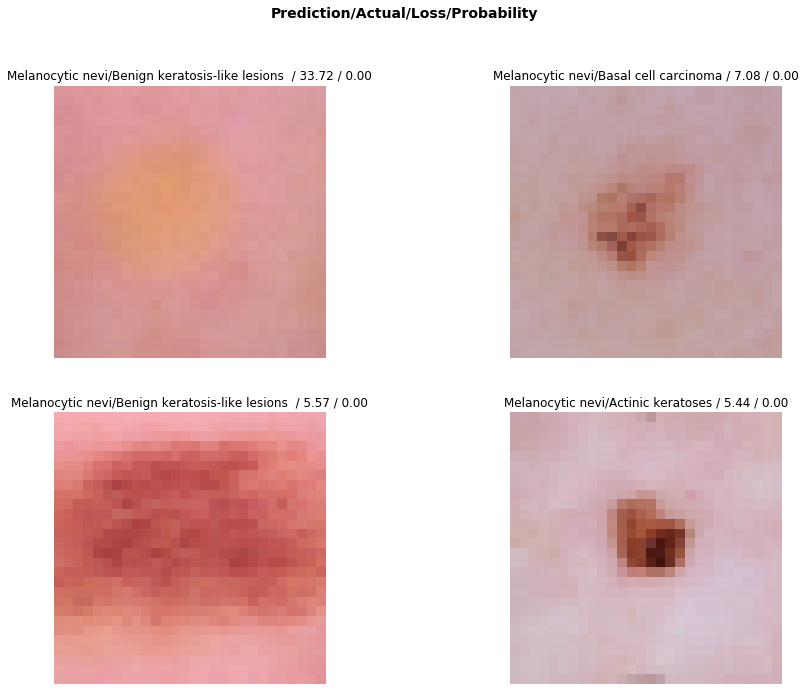

In [0]:
interp.plot_top_losses(4, figsize=(15,11))

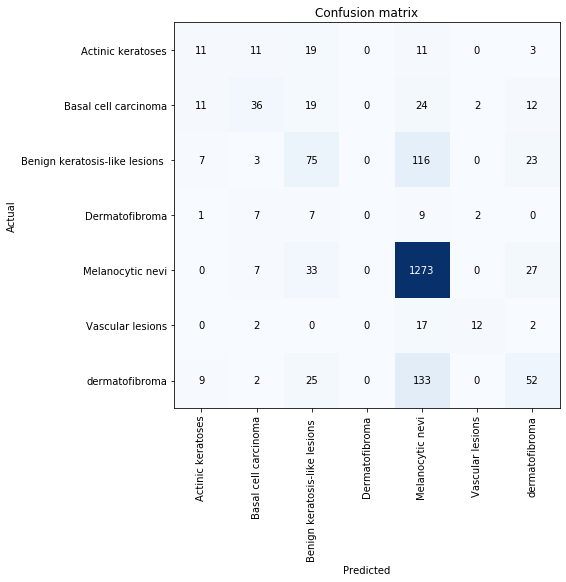

In [0]:
interp.plot_confusion_matrix(figsize=(10,8))

In [0]:

interp.most_confused(min_val=19)

[('dermatofibroma', 'Melanocytic nevi', 133),
 ('Benign keratosis-like lesions ', 'Melanocytic nevi', 116),
 ('Melanocytic nevi', 'Benign keratosis-like lesions ', 33),
 ('Melanocytic nevi', 'dermatofibroma', 27),
 ('dermatofibroma', 'Benign keratosis-like lesions ', 25),
 ('Basal cell carcinoma', 'Melanocytic nevi', 24),
 ('Benign keratosis-like lesions ', 'dermatofibroma', 23),
 ('Actinic keratoses', 'Benign keratosis-like lesions ', 19),
 ('Basal cell carcinoma', 'Benign keratosis-like lesions ', 19)]

# Unfreeze

In [0]:

learner.unfreeze()

In [0]:
learner.fit_one_cycle(1)

epoch,train_loss,valid_loss,accuracy,time
0,0.761726,0.684432,0.753869,01:40


In [0]:
learner.load('stage-1');

In [0]:

learner.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


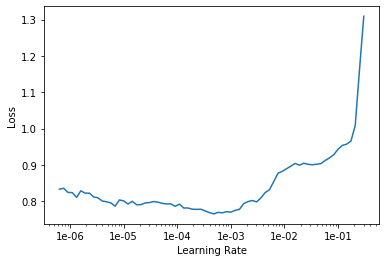

In [0]:

learner.recorder.plot()

In [0]:
learner.unfreeze()
learner.fit_one_cycle(2, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,accuracy,time
0,0.802771,0.741163,0.727908,01:40
1,0.766304,0.735360,0.736895,01:41


## Predictions

In [0]:
# Predictions of the validation data
preds_val, y_val=learner.get_preds()

In [0]:
predictor = create_cnn(pred_data, models.resnet50, model_dir="/tmp/model/").load('stage-1')

NameError: ignored

### Roc Curve
With the ROC curve we will mesuare how good it's our model

- A receiver operating characteristic curve, or ROC curve, is a graphical plot that illustrates the diagnostic ability of a binary classifier system as its discrimination threshold is varied. 
- The ROC curve is created by plotting the true positive rate against the false positive rate at various threshold settings.
<img width="800" src="https://st3.ning.com/topology/rest/1.0/file/get/1341805045?profile=original">

- With a ROC curve, you're trying to find a good model that optimizes the trade off between the False Positive Rate (FPR) and True Positive Rate (TPR).  
- What counts here is how much area is under the curve (Area under the Curve = AuC). 
- The ideal curve in the left image fills in 100%, which means that you're going to be able to distinguish between negative results and positive results 100% of the time (which is almost impossible in real life). 
- The further you go to the right, the worse the detection. 
- The ROC curve to the far right does a worse job than chance, mixing up the negatives and positives (which means you likely have an error in your setup).

In [0]:
#  ROC curve
fpr, tpr, thresholds = roc_curve(y_val.numpy(), preds_val.numpy()[:,1], pos_label=1)

#  ROC area
pred_score = auc(fpr, tpr)
print(f'ROC area is {pred_score}')

In [0]:
plt.figure()
plt.plot(fpr, tpr, color='orange', label='ROC curve (area = %0.2f)' % pred_score)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

# Prediction

In [0]:
learner.to_fp32()   #I think that in latest version of fastai you don't have to come back 
                    #from half_precision, but here gives me an error when running TTA.
int=learner.interpret(tta=True)

In [0]:
int.plot_confusion_matrix(figsize=(6,6))

In [0]:
int.plot_top_losses(4, figsize=(17,17), heatmap=True)